# Hydro Availability Builder

**Objective**  
- Transform monthly reservoir and run-of-river (ROR) hydro profiles into the seasonal and hourly availability CSVs (`pAvailabilityCustom.csv` and `pVREgenProfile.csv`) required by EPM.
- Ensure consistency with pGenDataInput and complete if necessary.

**Data requirements (user-provided) and method**  
- Data requirements: Monthly capacity-factor CSVs per plant/zone (default `input/hydro_profile_dry.csv`), plant metadata fields (`gen`, `zone`, `tech`), and the official `pHours.csv` template from `epm/input/` to align the season-daytype-hour structure.  
- Method: Validate inputs, align them with the `pHours` calendar, aggregate reservoir series to seasonal capacity factors, reshape ROR series into the long hourly format, and export review-ready CSVs.

**Overview of steps**  
1. Step 1 - Capture the user inputs describing folders, scenario tags, and technology filters.  
2. Step 2 - Create the working/output folders and load the template layout.  
3. Step 3 - Load the hydro profiles plus the `pHours` calendar.  
4. Step 4 - Cross-check hydro coverage against `pGenDataInput` to flag missing capacity-factor rows.  
5. Step 5 - Process reservoir and ROR data into the `pAvailabilityCustom` and `pVREgenProfile` tables, then save them for QA.

## 1. User Inputs

Fill these once and rerun if you need to change the source data or template. Files are resolved relative to `pre-analysis/prepare-data/`.

In [ ]:
# Path to the monthly hydro profile CSV stored under `input/`
input_profile_filename = 'hydro_profile_baseline.csv'

# Folder under `epm/input/` containing the scenario-specific inputs
folder_epm_input = 'data_sapp'

# Filenames relative to `epm/input/<folder_epm_input>/`
hours_template_filename = 'pHours.csv'
pGenDataInput_filename = 'pGenDataInput.csv'

# Optional: list the zones to process (e.g. ['Angola', 'Cameroon']). Leave empty to include every zone found in the hydro profile.
#zones = ['Angola', 'Cameroon', 'CAR', 'Chad', 'Congo', 'DRC', 'EquatorialGuinea', 'Gabon', 'DRC_South']
zones = []

# Month to season to consier
MONTH_TO_SEASON = {
    1: '2', 2: '2', 3: '2',
    4: '2', 5: '1', 6: '1',
    7: '1', 8: '1', 9: '1',
    10: '2', 11: '2', 12: '2',
}


## 2. Setup: imports, folders, and helpers

Run once to load libraries and create the working folders referenced later in the notebook.

In [2]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

folder_input = 'input'
folder_output = 'output'
os.makedirs(folder_output, exist_ok=True)
print(f'Input folder: {folder_input}')
print(f'Output folder: {folder_output}')

Input folder: input
Output folder: output


## 3. Load hydro profiles and the pHours template

Validates the user inputs, loads the monthly hydro profiles, and reads the pHours layout that drives the seasonal/daytype structure.

In [3]:

input_path = Path(folder_input) / input_profile_filename
if not input_path.exists():
    raise FileNotFoundError(f'Cannot find {input_path}. Double-check `input_profile_filename`.')

hydro_data = pd.read_csv(input_path, index_col=None, header=0, encoding='latin1') # latin1 #utf-8-sig
for col in ('gen', 'zone', 'tech'):
    if col in hydro_data.columns:
        hydro_data[col] = hydro_data[col].astype(str).str.strip()

zone_candidates = []
if isinstance(zones, str):
    zone_candidates = [chunk.strip() for chunk in zones.split(',') if chunk.strip()]
elif zones is None:
    zone_candidates = []
else:
    try:
        iterator = iter(zones)
    except TypeError:
        zone_str = str(zones).strip()
        zone_candidates = [zone_str] if zone_str else []
    else:
        for value in iterator:
            if value is None:
                continue
            zone_str = str(value).strip()
            if zone_str:
                zone_candidates.append(zone_str)

available_zones = set(hydro_data['zone'].dropna().unique())
if zone_candidates:
    missing_zones = sorted(set(zone_candidates) - available_zones)
    if missing_zones:
        print(f"Warning: the following zones are not present in {input_path.name} and will be ignored: {', '.join(missing_zones)}")
    hydro_data = hydro_data[hydro_data['zone'].isin(zone_candidates)].copy()
    if hydro_data.empty:
        raise ValueError('No hydro rows remain after applying the `zones` filter. Update `zones` to match the data.')

selected_zones = sorted(hydro_data['zone'].dropna().unique())
if not selected_zones:
    raise ValueError('No valid zone entries found in the hydro profile. Ensure the `zone` column is populated.')
if zone_candidates:
    print(f"Filtering hydro profile to {len(selected_zones)} zone(s): {', '.join(selected_zones)}")
else:
    print(f"No `zones` filter supplied; using all {len(selected_zones)} zone(s): {', '.join(selected_zones)}")

value_columns = [col for col in hydro_data.columns if col not in ('gen', 'zone', 'tech')]
if not value_columns:
    raise ValueError('The hydro profile file does not contain any monthly capacity-factor columns.')

print(f'Loaded hydro profile: {input_path.name} with {len(hydro_data)} rows after filtering')

epm_input_root = Path('../../epm/input')
hours_template_file = Path(os.path.join(str(epm_input_root), folder_epm_input, hours_template_filename))
if not hours_template_file.exists():
    raise FileNotFoundError(f'Cannot find {hours_template_file}. Update `hours_template_filename` or `folder_epm_input`.')

template = pd.read_csv(hours_template_file)
print(f'Loaded pHours template from {hours_template_file}')

pGenDataInput_file = Path(os.path.join(str(epm_input_root), folder_epm_input, 'supply', pGenDataInput_filename))
if pGenDataInput_file is None:
    raise FileNotFoundError('Cannot find pGenDataInput in the scenario folder (checked root and `supply/`).')

pgen_data = pd.read_csv(pGenDataInput_file, encoding='utf-8-sig')
for col in ('gen', 'zone', 'tech', 'fuel'):
    if col in pgen_data.columns:
        pgen_data[col] = pgen_data[col].astype(str).str.strip()

print(f'Loaded pGenDataInput from {pGenDataInput_file}')


Filtering hydro profile to 8 zone(s): Angola, CAR, Cameroon, Congo, DRC, DRC_South, EquatorialGuinea, Gabon
Loaded hydro profile: hydro_profile_baseline.csv with 97 rows after filtering
Loaded pHours template from ../../epm/input/data_capp/pHours.csv
Loaded pGenDataInput from ../../epm/input/data_capp/supply/pGenDataInput.csv


## 4. Validate generators against `pGenDataInput`

Compare the hydro units included in the monthly capacity-factor file with those defined in `pGenDataInput` so any gaps can be filled before exporting the availability tables.

In [7]:

profile_gens = hydro_data['gen'].astype(str).str.strip()
profile_gen_set = set(profile_gens)
profile_zone_lookup = hydro_data.assign(gen=profile_gens, zone=hydro_data['zone'].astype(str).str.strip()).set_index('gen')['zone'].to_dict()

hydro_mask = pgen_data['fuel'].astype(str).str.contains('Water', case=False, na=False) * pgen_data['Status'].isin([1, 2, 3])
pgen_hydro = pgen_data[hydro_mask].copy()
pgen_hydro['gen'] = pgen_hydro['gen'].astype(str).str.strip()
pgen_hydro['zone'] = pgen_hydro['zone'].astype(str).str.strip()
selected_zone_set = set(selected_zones) if 'selected_zones' in globals() else set()
if selected_zone_set:
    pgen_hydro = pgen_hydro[pgen_hydro['zone'].isin(selected_zone_set)].copy()

pgen_gen_set = set(pgen_hydro['gen'])
zone_lookup = pgen_hydro.set_index('gen')['zone'].to_dict()

missing_profiles = sorted(pgen_gen_set - profile_gen_set)
missing_in_pgen = sorted(profile_gen_set - pgen_gen_set)

zone_peer_map = (
    hydro_data.assign(gen=profile_gens, zone=hydro_data['zone'].astype(str).str.strip())
        .groupby('zone')['gen']
        .apply(lambda s: sorted(s.tolist()))
        .to_dict()
)

numeric_matrix = hydro_data[['zone', 'gen']].copy()
numeric_matrix['tech'] = hydro_data['tech'].astype(str).str.strip()
for col in value_columns:
    numeric_matrix[col] = pd.to_numeric(hydro_data[col], errors='coerce')

zone_cf_template = numeric_matrix.groupby('zone')[value_columns].mean()
zone_tech_cf_template = (
    numeric_matrix.dropna(subset=['tech'])
        .groupby(['zone', 'tech'])[value_columns]
        .mean()
)
zone_avg_cf = zone_cf_template.mean(axis=1).to_dict()
zone_tech_avg_cf = zone_tech_cf_template.mean(axis=1).to_dict()

if missing_profiles:
    print(f"{len(missing_profiles)} hydro generators are defined in pGenDataInput but missing capacity-factor profiles:")
    impacted_zones = set()
    for gen in missing_profiles:
        zone = zone_lookup.get(gen, 'Unknown')
        impacted_zones.add(zone)
        peers = [peer for peer in zone_peer_map.get(zone, []) if peer != gen]
        tech = 'Unknown'
        if 'tech' in pgen_hydro.columns:
            tech = pgen_hydro.loc[pgen_hydro['gen'] == gen, 'tech']
            tech = tech.iloc[0] if not tech.empty else 'Unknown'
        avg_cf = zone_tech_avg_cf.get((zone, tech))
        avg_source = f"zone {zone} ({tech})" if pd.notna(avg_cf) else None
        if avg_source is None:
            avg_cf = zone_avg_cf.get(zone)
            avg_source = f"zone {zone}"
        if peers and pd.notna(avg_cf):
            print(f"  - {gen} (zone {zone}, tech {tech}): add values by averaging existing hydro in {avg_source} ({', '.join(peers)}) → suggested mean CF {avg_cf:.3f}.")
        else:
            print(f"  - {gen} (zone {zone}, tech {tech}): no peer hydro available; please enter CFs manually.")
    available_zones = sorted(zone for zone in impacted_zones if zone in zone_cf_template.index)
    if available_zones:
        print('Zone-average monthly profiles for the impacted zones:')
        display(zone_cf_template.loc[available_zones].round(3))
else:
    print('All hydro generators in pGenDataInput have matching capacity-factor profiles.')



if missing_in_pgen:
    print(f"{len(missing_in_pgen)} generators have capacity-factor rows here but are missing from pGenDataInput:")
    for gen in missing_in_pgen:
        zone = profile_zone_lookup.get(gen, 'Unknown')
        print(f"  - {gen} (zone {zone}): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.")
else:
    print('No extra hydro capacity-factor rows beyond what pGenDataInput expects.')


13 hydro generators are defined in pGenDataInput but missing capacity-factor profiles:
  - Bikomo (zone EquatorialGuinea, tech ROR): add values by averaging existing hydro in zone EquatorialGuinea (Djibloho, Djibloho 2, Sendje) → suggested mean CF 0.517.
  - Bongolo (zone Gabon, tech ReservoirHydro): add values by averaging existing hydro in zone Gabon (ReservoirHydro) (Boou, Chute de Tsamba, Chutes de l'Imperatrice, Defile de Mitoungou, Dibwangui, FE-2 (Kinguele Aval), Grand Poubara, Kinguele, Kongue, Kouata Mango, Lifouta, Ngoulmendjim, Poubara, Tchimbele, Tsengue Leledi) → suggested mean CF 0.524.
  - Booue (zone Gabon, tech ReservoirHydro): add values by averaging existing hydro in zone Gabon (ReservoirHydro) (Boou, Chute de Tsamba, Chutes de l'Imperatrice, Defile de Mitoungou, Dibwangui, FE-2 (Kinguele Aval), Grand Poubara, Kinguele, Kongue, Kouata Mango, Lifouta, Ngoulmendjim, Poubara, Tchimbele, Tsengue Leledi) → suggested mean CF 0.524.
  - Bousanga (zone DRC_South, tech Rese

,1,2,3,4,5,6,7,8,9,10,11,12
zone,,,,,,,,,,,,
Angola,0.627,0.698,0.868,0.846,0.526,0.223,0.118,0.091,0.099,0.129,0.278,0.448
Congo,0.495,0.521,0.546,0.571,0.527,0.354,0.265,0.224,0.298,0.384,0.636,0.615
DRC,0.673,0.703,0.813,0.827,0.771,0.634,0.550,0.481,0.474,0.461,0.550,0.580
DRC_South,0.828,0.980,0.944,0.880,0.760,0.700,0.620,0.560,0.430,0.400,0.370,0.320
EquatorialGuinea,0.350,0.307,0.320,0.633,0.697,0.693,0.327,0.170,0.497,0.757,0.757,0.697
Gabon,0.547,0.517,0.519,0.589,0.587,0.466,0.333,0.254,0.389,0.575,0.770,0.721


19 generators have capacity-factor rows here but are missing from pGenDataInput:
  - Bac + Lotomo (zone CAR): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Bendera (zone DRC): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Boou (zone Gabon): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Defile de Mitoungou (zone Gabon): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Djibloho 2 (zone EquatorialGuinea): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Djoue Rebuild (zone Congo): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Inga (zone DRC): either remove it from the hydro profile or add the unit to pGenDataInput so EPM can use it.
  - Kimbombo (zone DRC): either remove it from the hydro profile or

### 4b - Build zone-average placeholders for missing generators


In [8]:

# Build placeholder monthly capacity-factor profiles for generators missing in the hydro file.
derived_cf_profiles = pd.DataFrame(columns=['gen', 'zone', 'tech', *value_columns])
if missing_profiles:
    tech_lookup = {}
    if not pgen_hydro.empty and 'tech' in pgen_hydro.columns:
        tech_lookup = (
            pgen_hydro.assign(tech=pgen_hydro['tech'].astype(str).str.strip())
            .set_index('gen')['tech']
            .to_dict()
        )

    fill_rows = []
    skipped_missing = []
    for gen in missing_profiles:
        zone = zone_lookup.get(gen, 'Unknown')
        tech = tech_lookup.get(gen, 'Unknown')
        template_key = (zone, tech)
        zone_profile = None
        if template_key in zone_tech_cf_template.index:
            zone_profile = zone_tech_cf_template.loc[template_key]
        elif zone in zone_cf_template.index:
            zone_profile = zone_cf_template.loc[zone]
        if zone_profile is None:
            skipped_missing.append(gen)
            continue

        row = {
            'gen': gen,
            'zone': zone,
            'tech': tech,
        }
        for col in value_columns:
            row[col] = zone_profile[col]
        fill_rows.append(row)

    if fill_rows:
        derived_cf_profiles = pd.DataFrame(fill_rows, columns=['gen', 'zone', 'tech', *value_columns])
        print(f'Prepared placeholders for {len(derived_cf_profiles)} generator(s) using zone/technology averages.')
        display(derived_cf_profiles.head())
    else:
        print('Missing generators detected but no zone or zone-tech averages available to build placeholders.')

    if skipped_missing:
        print('Skipped generators without valid averages:', ', '.join(skipped_missing))
else:
    print('No missing hydro generators -> placeholder DataFrame empty.')


Prepared placeholders for 13 generator(s) using zone/technology averages.


,gen,zone,tech,1,2,3,4,5,6,7,8,9,10,11,12
0,Bikomo,EquatorialGuinea,ROR,0.350000,0.306667,0.320000,0.633333,0.696667,0.693333,0.326667,0.170000,0.496667,0.756667,0.756667,0.696667
1,Bongolo,Gabon,ReservoirHydro,0.536667,0.491667,0.490833,0.578333,0.580000,0.487500,0.350833,0.265833,0.439167,0.610833,0.750000,0.707500
2,Booue,Gabon,ReservoirHydro,0.536667,0.491667,0.490833,0.578333,0.580000,0.487500,0.350833,0.265833,0.439167,0.610833,0.750000,0.707500
3,Bousanga,DRC_South,ReservoirHydro,0.828000,0.980000,0.944000,0.880000,0.760000,0.700000,0.620000,0.560000,0.430000,0.400000,0.370000,0.320000
4,Kilubi,DRC_South,ReservoirHydro,0.828000,0.980000,0.944000,0.880000,0.760000,0.700000,0.620000,0.560000,0.430000,0.400000,0.370000,0.320000


### 4c - Completed hydro capacity-factor profile and QA plots


Completed capacity-factor table contains 110 generator rows across 8 zone(s).


,zone,gen,tech,1,2,3,4,5,6,7,8,9,10,11,12
0,Angola,AH Mabubas,ROR,1.00,1.00,1.0,1.00,0.22,0.06,0.02,0.01,0.01,0.02,0.08,0.58
1,Angola,Baynes,ReservoirHydro,0.33,0.23,0.4,0.77,0.79,0.34,0.29,0.20,0.11,0.06,0.09,0.30
2,Angola,Cacula Cabasa,ROR,0.51,0.76,1.0,1.00,0.76,0.13,0.02,0.01,0.02,0.07,0.57,0.30
3,Angola,Cafula (Keve),ROR,0.84,0.67,1.0,1.00,0.25,0.05,0.01,0.01,0.01,0.07,0.22,0.74
4,Angola,Calengue (Catumbela),ROR,0.51,0.76,1.0,1.00,0.76,0.13,0.02,0.01,0.02,0.07,0.57,0.30


All hydro generators defined in pGenDataInput now have capacity-factor rows.


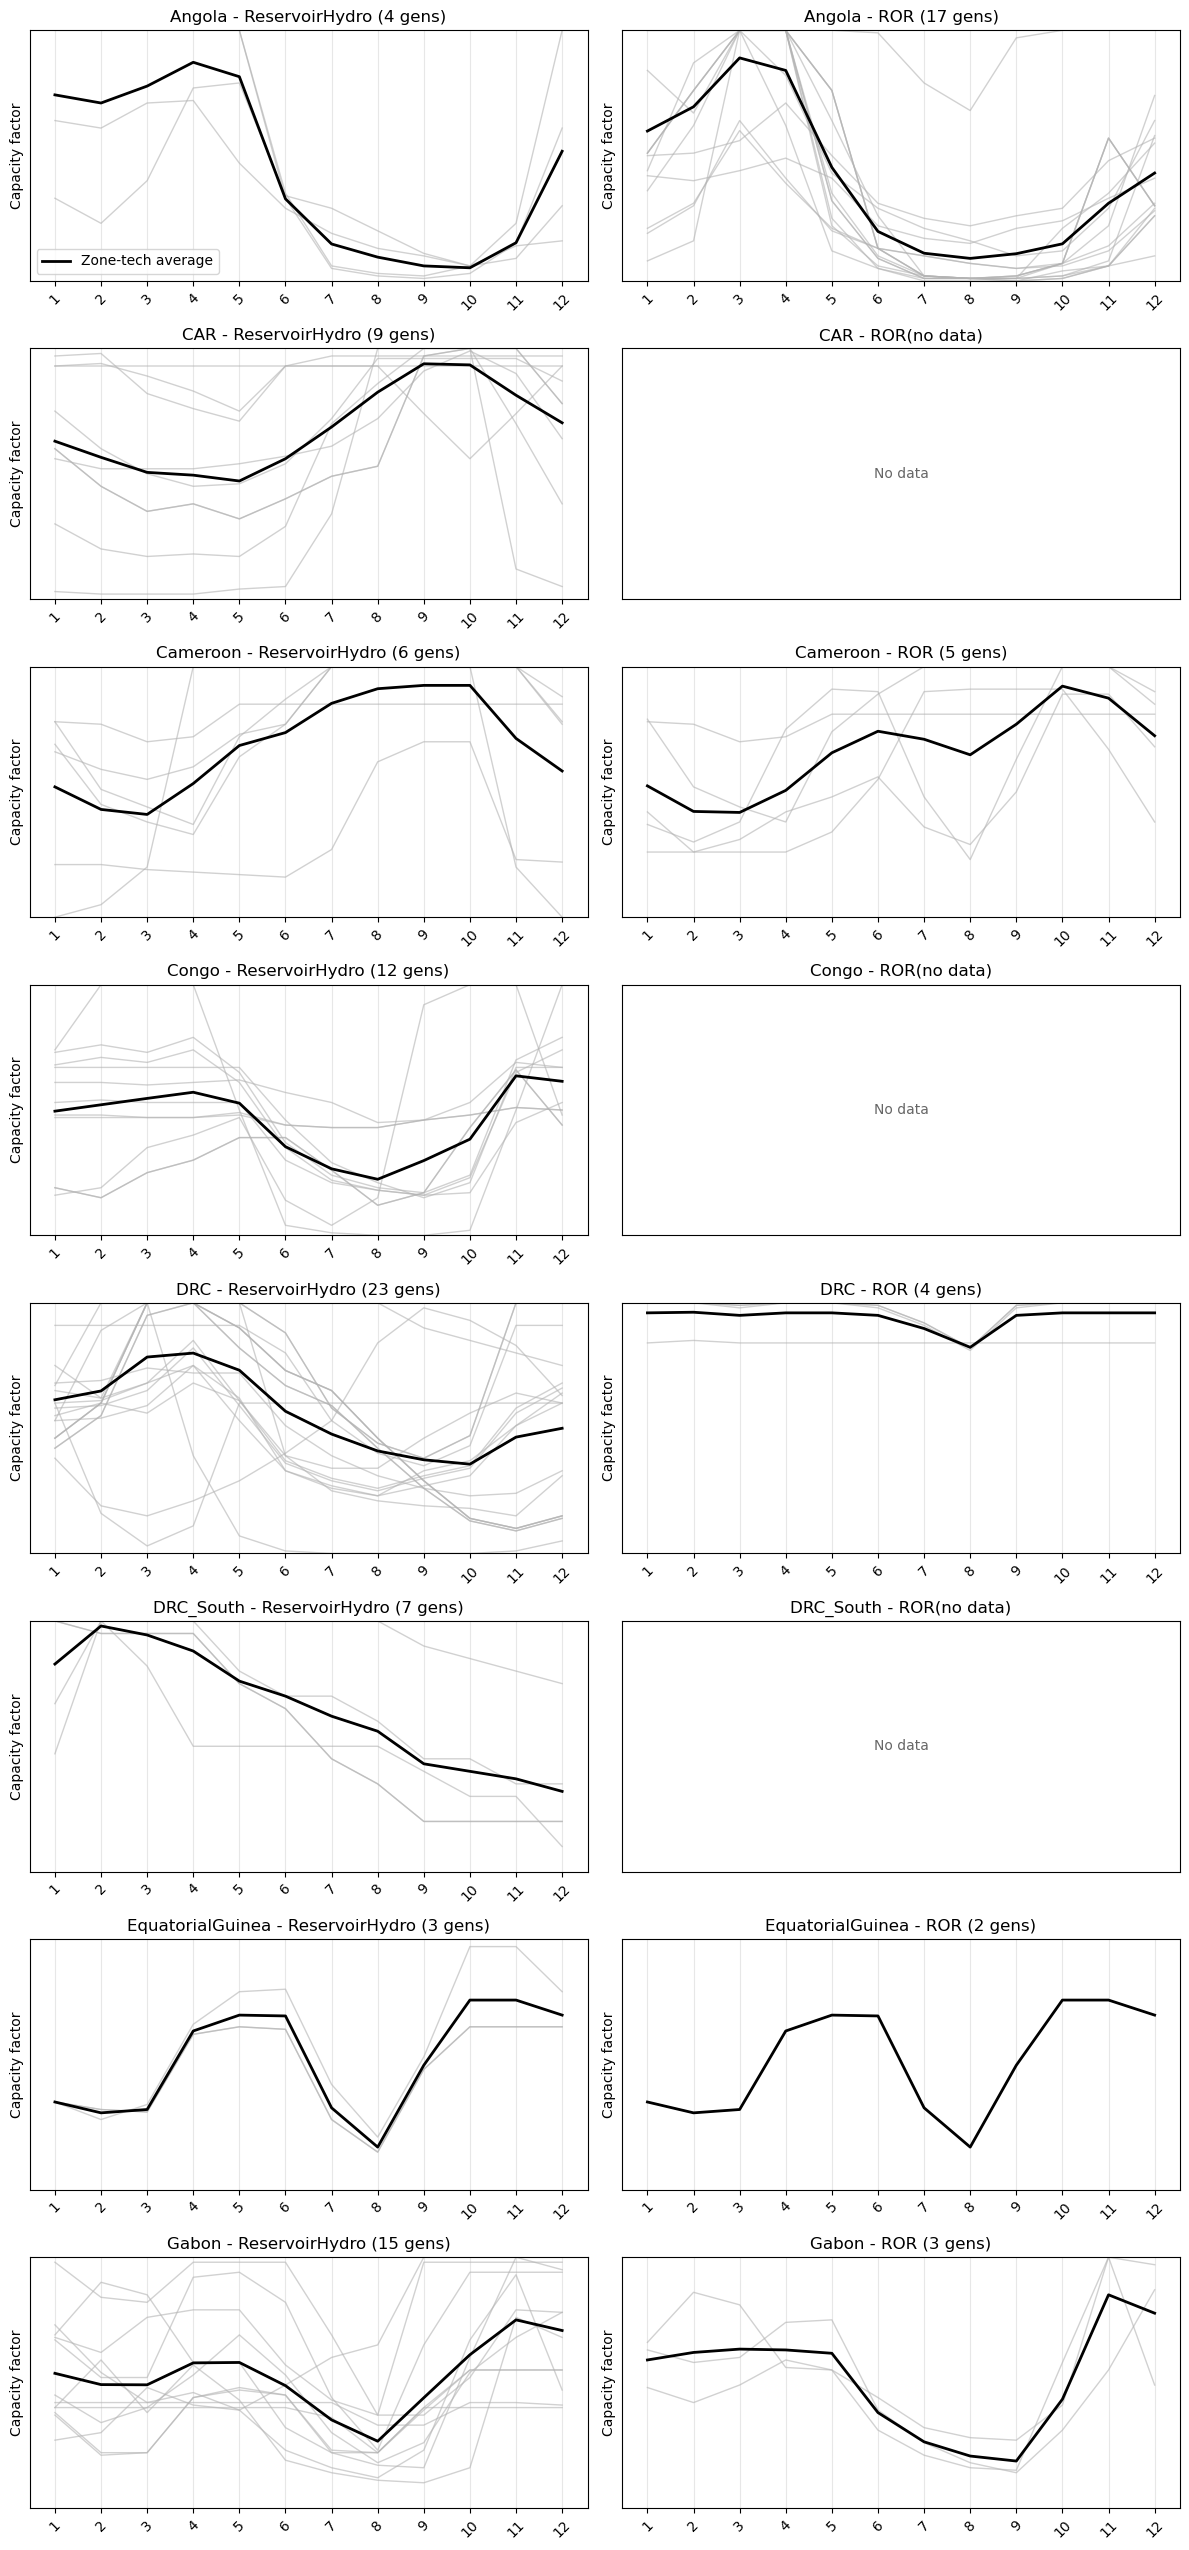

In [9]:

# Combine the original hydro profiles with any derived zone-average placeholders.
cf_profile_completed = hydro_data.copy()
if not derived_cf_profiles.empty:
    cf_profile_completed = pd.concat([hydro_data, derived_cf_profiles], ignore_index=True)

cf_profile_completed[value_columns] = cf_profile_completed[value_columns].apply(pd.to_numeric, errors='coerce')
cf_profile_completed = cf_profile_completed.drop_duplicates(subset=['gen']).sort_values(['zone', 'gen']).reset_index(drop=True)

print(f"Completed capacity-factor table contains {len(cf_profile_completed)} generator rows across {cf_profile_completed['zone'].nunique()} zone(s).")
display(cf_profile_completed.head())

completed_gen_set = set(cf_profile_completed['gen'])
remaining_missing = sorted(pgen_gen_set - completed_gen_set)
if remaining_missing:
    preview = ', '.join(remaining_missing[:10])
    more = '...' if len(remaining_missing) > 10 else ''
    print(f"Still missing {len(remaining_missing)} generator(s) after filling: {preview}{more}")
else:
    print('All hydro generators defined in pGenDataInput now have capacity-factor rows.')


# Plot monthly capacity factors with zone/technology averages.
zones_to_plot = sorted(cf_profile_completed['zone'].dropna().unique())
tech_columns = ['ReservoirHydro', 'ROR']
if not zones_to_plot:
    print('No zones available for plotting capacity-factor profiles.')
else:
    fig, axes = plt.subplots(len(zones_to_plot), len(tech_columns), figsize=(6 * len(tech_columns), 3.2 * len(zones_to_plot)), squeeze=False, sharey=True)
    legend_drawn = False

    for row_idx, zone in enumerate(zones_to_plot):
        for col_idx, tech in enumerate(tech_columns):
            ax = axes[row_idx][col_idx]
            mask = (cf_profile_completed['zone'] == zone) & (cf_profile_completed['tech'] == tech)
            zone_tech_df = cf_profile_completed[mask]

            if zone_tech_df.empty:
                ax.set_title(f"{zone} - {tech}(no data)")
                ax.set_xticks([])
                ax.set_yticks([])
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='0.4')
                continue

            zone_values = zone_tech_df[value_columns].astype(float)
            for _, row in zone_values.iterrows():
                ax.plot(value_columns, row.values, color='0.7', linewidth=1, alpha=0.6)

            zone_avg = zone_values.mean(axis=0)
            ax.plot(value_columns, zone_avg.values, color='black', linewidth=2, label='Zone-tech average')

            ax.set_title(f"{zone} - {tech} ({len(zone_tech_df)} gens)")
            ax.set_xticks(range(len(value_columns)))
            ax.set_xticklabels(value_columns, rotation=45)
            ax.set_ylabel('Capacity factor')
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)
            if not legend_drawn:
                ax.legend()
                legend_drawn = True

    fig.tight_layout()
    plt.show()


## 5 - Process hydro availability

### 5a - Build seasonal reservoir availability

In [10]:
# Keep only Reservoir Hydro units and the monthly columns.
data_reservoir = cf_profile_completed[cf_profile_completed['tech'] == 'ReservoirHydro'].copy()
data_reservoir.set_index(['gen'], inplace=True)
data_reservoir.drop(columns=['zone', 'tech'], inplace=True)
data_reservoir.columns = data_reservoir.columns.astype(int)
display(data_reservoir.head())

# Convert months to seasons using MONTH_TO_SEASON and compute the mean for each season.
data_reservoir = data_reservoir.T.groupby(MONTH_TO_SEASON).mean().T

# Rename the season columns with the expected Q prefix and persist the output.
data_reservoir.columns = [f'Q{col}' for col in data_reservoir.columns]
data_reservoir.columns.names = ['season']
display(data_reservoir.head())

output_path_reservoir = os.path.join(folder_output, 'pAvailabilityCustom.csv')
data_reservoir.to_csv(output_path_reservoir)
print(f"Reservoir data processed and saved to {output_path_reservoir}")


,1,2,3,4,5,6,7,8,9,10,11,12
gen,,,,,,,,,,,,
Baynes,0.33,0.23,0.40,0.77,0.79,0.34,0.29,0.20,0.11,0.06,0.09,0.30
Cambambe,1.00,1.00,1.00,1.00,1.00,0.33,0.05,0.02,0.01,0.03,0.15,0.61
Capanda,1.00,1.00,1.00,1.00,1.00,0.35,0.06,0.03,0.02,0.06,0.23,1.00
Gove,0.64,0.61,0.71,0.72,0.47,0.29,0.19,0.13,0.10,0.06,0.14,0.16
Bac + Lotomo,0.56,0.52,0.52,0.52,0.54,0.57,0.61,0.72,0.91,0.99,0.90,0.64


season,Q1,Q2
gen,,
Baynes,0.346,0.311429
Cambambe,0.282,0.684286
Capanda,0.292,0.755714
Gove,0.236,0.434286
Bac + Lotomo,0.670,0.664286


Reservoir data processed and saved to output/pAvailabilityCustom.csv


### 5b - Format run-of-river hourly availability

In [11]:
def build_ror_generation_profile(result, template):
    """Build the long-run hourly ROR profile expected by pVREgenProfile.csv."""

    # Flatten the seasonal input and broadcast each value across the template's hours.
    result_reset = result.reset_index()
    result_long = result_reset.melt(id_vars='gen', var_name='season', value_name='value')

    template_pairs = template[['season', 'daytype']].drop_duplicates().reset_index(drop=True)
    merged = result_long.merge(template_pairs, on='season', how='left')

    if merged['daytype'].isna().any():
        missing_seasons = ', '.join(sorted(merged.loc[merged['daytype'].isna(), 'season'].unique()))
        raise ValueError(f'Template is missing daytype definitions for: {missing_seasons}')

    hour_cols = [col for col in template.columns if col not in ('season', 'daytype')]
    for col in hour_cols:
        merged[col] = merged['value']

    merged_final = merged.drop(columns=['value'])
    ordered_cols = ['gen', 'season', 'daytype', *hour_cols]
    return merged_final[ordered_cols]


In [12]:
# Filter to Run-of-River units and retain monthly columns only.
data_ror = cf_profile_completed[cf_profile_completed['tech'] == 'ROR'].copy()
if data_ror.empty:
    print('No ROR generators found. Skipping pVREgenProfile export.')
else:
    data_ror.set_index(['gen'], inplace=True)
    data_ror.drop(columns=['zone', 'tech'], inplace=True)
    data_ror[value_columns] = data_ror[value_columns].apply(pd.to_numeric, errors='coerce')
    data_ror.columns = data_ror.columns.astype(int)
    display(data_ror.head())

    # Convert months to seasons and label them with the Q prefix.
    data_ror = data_ror.T.groupby(MONTH_TO_SEASON).mean().T
    display(data_ror.head())
    data_ror.columns = [f'Q{col}' for col in data_ror.columns]
    data_ror.columns.names = ['season']

    # Align with the template structure so downstream scripts can ingest the file directly.
    data_ror = build_ror_generation_profile(data_ror, template)
    column_order = ['gen', *template.columns.tolist()]
    data_ror = data_ror[column_order]
    display(data_ror.head())

    output_path_ror = os.path.join(folder_output, 'pVREgenProfile.csv')
    data_ror.to_csv(output_path_ror, index=False)
    print(f'ROR data processed and saved to {output_path_ror}')


,1,2,3,4,5,6,7,8,9,10,11,12
gen,,,,,,,,,,,,
AH Mabubas,1.00,1.00,1.00,1.00,0.22,0.06,0.02,0.01,0.01,0.02,0.08,0.58
Cacula Cabasa,0.51,0.76,1.00,1.00,0.76,0.13,0.02,0.01,0.02,0.07,0.57,0.30
Cafula (Keve),0.84,0.67,1.00,1.00,0.25,0.05,0.01,0.01,0.01,0.07,0.22,0.74
Calengue (Catumbela),0.51,0.76,1.00,1.00,0.76,0.13,0.02,0.01,0.02,0.07,0.57,0.30
Jamba Ya Mina,0.19,0.30,0.64,0.41,0.20,0.13,0.10,0.07,0.05,0.07,0.14,0.31


,1,2
gen,,
AH Mabubas,0.064,0.668571
Cacula Cabasa,0.188,0.601429
Cafula (Keve),0.066,0.648571
Calengue (Catumbela),0.188,0.601429
Jamba Ya Mina,0.110,0.294286


,gen,season,daytype,t1,t2,t3,t4,t5,t6,t7,...,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24
0,AH Mabubas,Q1,d1,0.064,0.064,0.064,0.064,0.064,0.064,0.064,...,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064
1,AH Mabubas,Q1,d2,0.064,0.064,0.064,0.064,0.064,0.064,0.064,...,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064
2,AH Mabubas,Q1,d3,0.064,0.064,0.064,0.064,0.064,0.064,0.064,...,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064
3,AH Mabubas,Q1,d4,0.064,0.064,0.064,0.064,0.064,0.064,0.064,...,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064
4,AH Mabubas,Q1,d5,0.064,0.064,0.064,0.064,0.064,0.064,0.064,...,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064,0.064


ROR data processed and saved to output/pVREgenProfile.csv
